<h2>Data cleansing an transformation approaches</h2>

* Group name: Bloodhounds
* Batch code: LISUM09
* Specialization: Data science
* Group member details:
* Margarita Prokhorovich, marusya15071240@gmail.com, Thailand

In [22]:
#reading the dataframe
import pandas as pd
df = pd.read_csv('bank-additional-full.csv', delimiter = ';')
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [23]:
#display the info about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

<h4>Drop duplicates - one approach</h4>
We can see that all the features have correct data types, and there's no null variables at the first glance. Now we need to check the dataframe for duplicates.

In [24]:
#find duplicates and display their quantity
n_duplicates = df.duplicated().sum()
print(f"Number of duplicates - {n_duplicates}.")

Number of duplicates - 12.


In [25]:
#delete all the full duplicates. We can see decreasing in a rows number
df = df.drop_duplicates()
df.shape

(41176, 21)

<h4>Pdays feature confusing vales - one approach</h4>
Next step is to explore pdays feature, since it cointains 999 values, it can affect the interpretation of a model. Let's find out how many rows have 999 value.

In [26]:
print(f'\nNumber of examples where a client was not previously contacted - {len(df[df.pdays == 999])}, percentage - {round(len(df[df.pdays == 999])/len(df) * 100,2)}%.')


Number of examples where a client was not previously contacted - 39661, percentage - 96.32%.


We can see that the ratio is quite large. To make sure we can look at the feature values distribution.

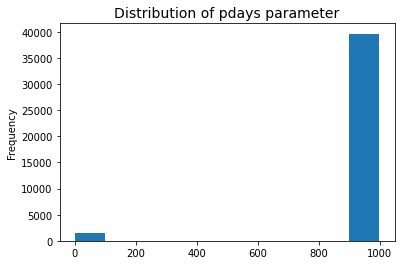

In [27]:
#plot pdays distribution
import matplotlib.pyplot as plt
df.pdays.plot(kind = 'hist')
plt.title('Distribution of pdays parameter', fontsize = 14);

Most of the feature values are equal to 999 and the rest of the values lie in quite a limited range. In this case we can transform this numeric value to a categorical one: 0 if value is equal to 999 and 1 if value is another.

In [28]:
df['pdays_categ'] = [0 if pday == 999 else 1 for pday in df.pdays]
df = df.drop(['pdays'], axis = 1)

<h4>Handle unknown values - four approaches</h4>
Next step is to study possible presence of null values more rigorously. First, let's check how many examples have 0 value.

In [30]:
print('Number of "0" occurrences:')
for i in df.columns:
    if 0 in set(df[i]):
        print("- feature - ", i, ", number - ", len(df[df[i] == 'unknown']), ", percentage -", round(len(df[df[i] == 0])/df.shape[0]*100,4), "%")

Number of "0" occurrences:
- feature -  duration , number -  0 , percentage - 0.0097 %
- feature -  previous , number -  0 , percentage - 86.3391 %
- feature -  pdays_categ , number -  0 , percentage - 96.3207 %


We can see that there's no any strange patterns. As for duration feature, it can have zero values if there was no responce from the client. Pdays feature also can have zero value since zero days have passed from the last marketing campaign. Finally, as for previous feature, if client wasn't contacted before, it could be zero. Now, let's check how many 'unknown' values categorical features have.

In [31]:
print('Number of "unknown" occurrences:')
for i in df.columns:
    if 'unknown' in set(df[i]):
        print("- feature - ", i, ", number - ", len(df[df[i] == 'unknown']), ", percentage -", round(len(df[df[i] == 'unknown'])/df.shape[0]*100,4), "%")

Number of "unknown" occurrences:
- feature -  job , number -  330 , percentage - 0.8014 %
- feature -  marital , number -  80 , percentage - 0.1943 %
- feature -  education , number -  1730 , percentage - 4.2015 %
- feature -  default , number -  8596 , percentage - 20.8762 %
- feature -  housing , number -  990 , percentage - 2.4043 %
- feature -  loan , number -  990 , percentage - 2.4043 %


We can see that all the features have quite a small share of unknown values except for default feature. We can remove the rows with such values but in this case some valuable data can be lost. Alternative option is to fill unknown values using different approaches. 

<b>The first approach - fill with the most frequent values</b>

First, we should look at categories distributions for each feature containing unknown values.

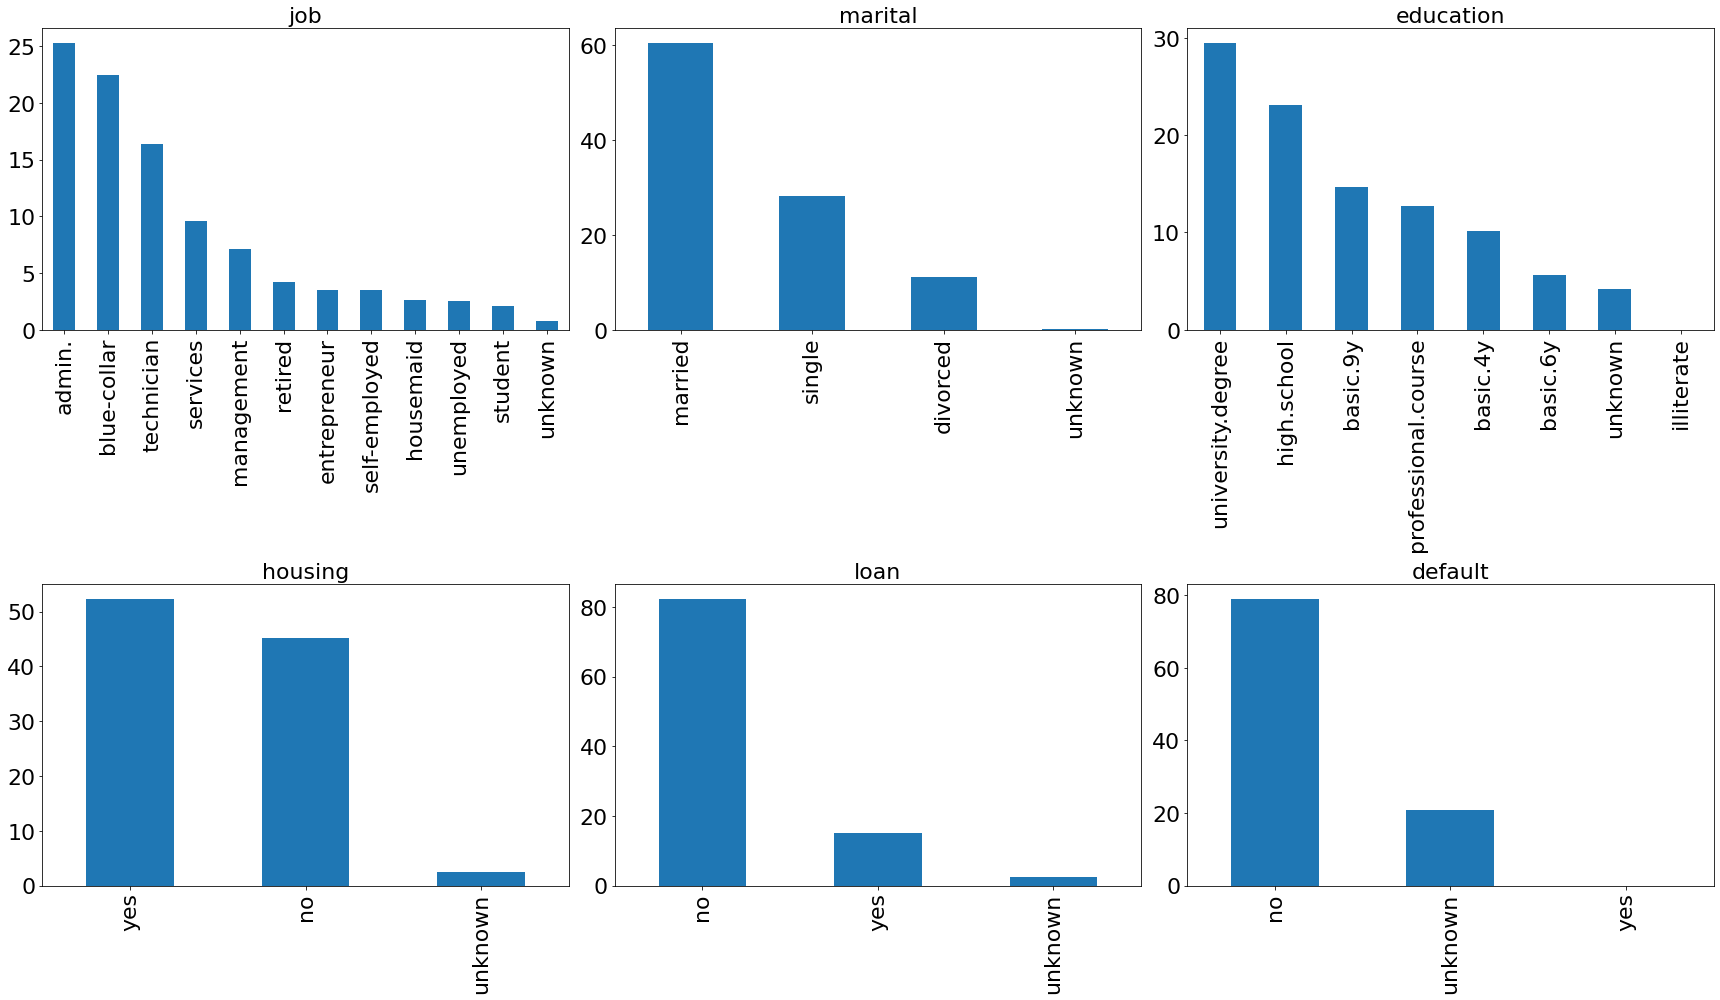

In [32]:
import matplotlib.pyplot as plt

categorical = ['job', 'marital', 'education', 'housing', 'loan', 'default']

#draw frequency plots for categorical variables
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(categorical,axs.reshape(-1), categorical):
   df[i].value_counts(normalize=True).mul(100).round(1).plot(kind='bar', ax = ax)
   ax.set_title(title, fontsize = 22)
   ax.tick_params(axis='both', labelsize=22)
fig.tight_layout()
plt.show()

We can see that in all the features values, except default, unknown values take quite a small percentage and adding it to the most frequent category won't affect imbalance between different categories badly. Since default feature has too many unknown values and this data is quite sensitive, it could be better to keep 'unknown' as a separate category.

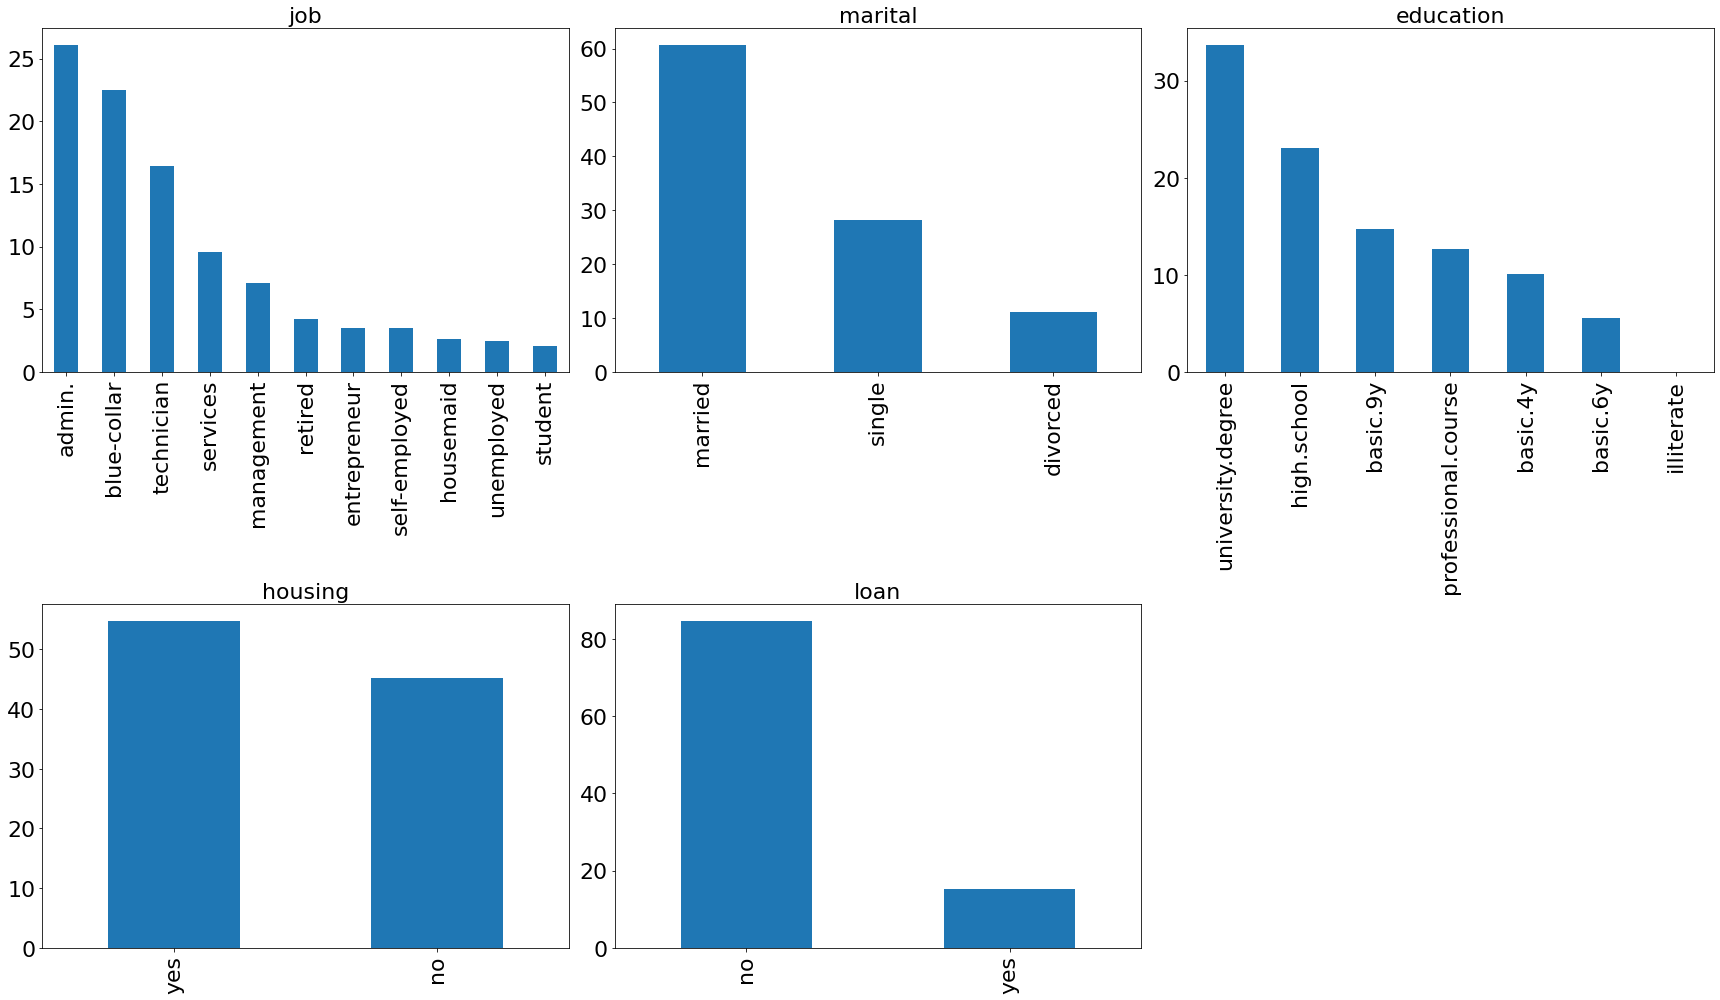

In [33]:
df_fill_mode = df.copy()
categorical = ['job', 'marital', 'education', 'housing', 'loan']

for i in categorical:
  df_fill_mode[i] = df_fill_mode[i].replace(to_replace = 'unknown', value = df_fill_mode[i].mode().iloc[0])

#draw frequency plots for categorical variables
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(categorical,axs.reshape(-1), categorical):
   df_fill_mode[i].value_counts(normalize=True).mul(100).round(1).plot(kind='bar', ax = ax)
   ax.set_title(title, fontsize = 22)
   ax.tick_params(axis='both', labelsize=22)
fig.delaxes(axs[1,2])
fig.tight_layout()
plt.show()

After filling unknown variables with the most frequent category values we can see that change in values distribution isn't dramatic. However, this approach makes not very jentle assumption that all unknown values belong to a 'mode' category. It especially affects binary features with high imbalance, such as housing and loan.

<b>The second approach - develop a model which could predict missing values</b>

We could solve a classification problem for each column with unknown values and build a model to predict such values. Since we have 6 features containing unknown values, it's needed to develop six different models.

We will use all the rest variables in prediction cause if we use some individual set of features (which affects each output feature the most), we can lose a part of information, we need to use the same set of features for prediction to save the whole picture. We'll treat ‘unknown’ values in other categorical input features as a separate class.

First, we need to encode out input and output categorical features. I'll use get_dummies method and Label Encoder for this purpose.
Further steps are the following:
* Divide the data into two parts. One part will have the present values of the column including the original output column, the other part will have the rows with the missing values.
* Divide the 1st part (present values) into cross-validation set for model selection.
* Train the models and test their metrics against the cross-validated data. 
* Finally, with the model, predict the unknown values.

In [34]:
#display, how many categories each feature has
categories = list(df.select_dtypes(exclude=['int64', 'float64']).columns)

# unique values in each columns
for x in df[categories]:
    #prinfting unique values
    print(x ,':', len(df[x].unique()))

job : 12
marital : 4
education : 8
default : 3
housing : 3
loan : 3
contact : 2
month : 10
day_of_week : 5
poutcome : 3
y : 2


In [35]:
#create an empty df where new filled columns will be stored
df_final = pd.DataFrame()

#define a function that predicts unknown values
def fill_unknown(column_name):   
   try: 
      #import necessary modules
      from sklearn.model_selection import train_test_split
      from sklearn.utils.class_weight import compute_class_weight
      from sklearn import preprocessing
      from sklearn.preprocessing import LabelEncoder
      from sklearn.linear_model import LogisticRegression
      from IPython.display import display
      import numpy as np

      #copy df
      df_copy = df.copy()

      #exclude binary features from categories
      global categories 
      categories = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
      categories = [i for i in categories if i not in [column_name, 'y', 'contact']]

      #transform another categorical features to dummy variables
      deleted_columns = []
      for i in categories:
         dummies_x = pd.get_dummies(df[i])
         deleted_columns.append(dummies_x.columns[0])
         df_copy = pd.concat([df_copy,dummies_x],axis='columns')

      #use label encoder
      le = LabelEncoder()
      #transform binary features - contact and y
      df_copy.contact = le.fit_transform(df_copy.contact)
      df_copy.y = le.fit_transform(df_copy.y)

      #delete columns - text categorical features and one from each encoded variables
      df_copy.drop(categories, axis = 1, inplace = True)
      df_copy.drop(deleted_columns, axis = 1, inplace = True)

      #split the dataframe to train set - without unknown variables and test - with unknown variables
      df_copy_train = df_copy[df_copy.loc[:, (column_name)] != 'unknown'].copy(deep = True)
      df_copy_test = df_copy[df_copy.loc[:, (column_name)] == 'unknown']
      #encode output variables
      df_copy_train['new_col'] = le.fit_transform(df_copy_train.loc[:, (column_name)])
      #assign a new column to y and drop  the column after that
      y = df_copy_train['new_col']
      df_copy_train.drop('new_col', axis = 1, inplace = True)

      #remove job column from train and test sets
      df_copy_train = df_copy_train.drop([column_name], axis='columns')
      df_copy_test = df_copy_test.drop([column_name], axis='columns')

      #Creating a model 
      #normalize data and split train set into train and validation sets
      scaler = preprocessing.StandardScaler().fit(df_copy_train)
      X_scaled = scaler.transform(df_copy_train)
      X_train, X_val, y_train, y_val = train_test_split(X_scaled,y,train_size=0.3)

      #calculating class weights since the data is imbalanced
      class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y = y)
      weight = {key: value for (key, value) in zip(np.unique(y), class_weights)}
      #training the model
      model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=10, class_weight=weight)
      model.fit(X_train, y_train)
      model.predict(X_val)
      print(f'Model accuracy for {column_name} is {round(model.score(X_val, y_val) * 100, 2)} %.')

      #save the model
      # filename = 'model.pkl'
      # pickle.dump(model, open(filename, 'wb'))

      #load the model
      #pickled_model = pickle.load(open(filename, 'rb'))

      #normalize X test data
      scaler_test = preprocessing.StandardScaler().fit(df_copy_test)
      X_test_scaled = scaler_test.transform(df_copy_test)

      #predict unknown values
      prediction = model.predict(X_test_scaled)

      #convert numbers to labels and create pd series
      df_copy_test[column_name] = le.inverse_transform(prediction)
      df_copy_test = df_copy_test[column_name].reset_index()
      df_copy_test = df_copy_test.set_index('index')

      #create a new dataframe and fill unknown values from created dataframe
      df_1 = df[df.loc[:, (column_name)] != 'unknown'].copy(deep = True)
      df_2 = df[df.loc[:, (column_name)] == 'unknown'].copy(deep = True)

      #assign pd series to a dataframe column and merge the dataframes
      df_2[column_name] = df_copy_test
      series_final = df_1.append(df_2)[column_name]
      global df_final
      df_final = pd.concat([df_final,series_final],axis='columns')
      return df_final
   except Exception as err:
      print('Since "default" feature has a little "yes" values, sometimes they are all concentrated in a cross-validation set. Please rerun the script one more time.') 
      return err

#apply the function to columns with unknown values
for i in ['job', 'marital', 'education', 'housing', 'loan', 'default']:
    df_fill = fill_unknown(i)
df_fill.head()

Model accuracy for job is 40.26 %.
Model accuracy for marital is 50.52 %.
Model accuracy for education is 48.7 %.
Model accuracy for housing is 54.23 %.
Model accuracy for loan is 49.36 %.
Model accuracy for default is 99.88 %.


,job,marital,education,housing,loan,default
0,housemaid,married,basic.4y,no,no,no
1,services,married,high.school,no,no,no
2,services,married,high.school,yes,no,no
3,admin.,married,basic.6y,no,no,no
4,services,married,high.school,no,yes,no


We can see that models' accuracy isn't high. It could be associated with big number of classes in some features, low relationship between input and output variables in general. Maybe the models could perform better with limited set of input features but, since all features are placed within the current data set, we find it more appropriate to include the same set of variables for all models. The only one model with high accuracy is a model for default feature. Since this feature values distribution is highly imbalanced, even adding class weight parameter to the model didn't solve the problem. So, this approach isn't acceptable for this feature and we again treat 'unknown' as a separate class here.

In [36]:
new_cols = [df_fill[i] for i in df_fill.columns if i != 'default']
df_log_reg = df.copy()
#assign new filled columns to the old ones in the dataframe
for i,y in zip(new_cols, df_fill.columns):
  df_log_reg[y] = i

#check that there's no any unknown values in these columns anymore
print('Number of "unknown" occurrences:')
for i in df_log_reg.columns:
    if 'unknown' in set(df_log_reg[i]):
        print("- feature - ", i, ", number - ", len(df_log_reg[df_log_reg[i] == 'unknown']), ", percentage -", round(len(df_log_reg[df_log_reg[i] == 'unknown'])/df.shape[0]*100,4), "%")
df_log_reg.sample(10)

Number of "unknown" occurrences:
- feature -  default , number -  8596 , percentage - 20.8762 %


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_categ
811,39,services,married,high.school,no,no,no,telephone,may,wed,...,1,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,0
20830,32,technician,single,university.degree,no,yes,no,cellular,aug,wed,...,5,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no,0
16921,35,blue-collar,divorced,basic.9y,unknown,yes,no,cellular,jul,thu,...,1,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0
18463,33,technician,single,professional.course,no,no,no,cellular,jul,thu,...,3,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no,0
28743,33,technician,married,professional.course,no,no,no,cellular,apr,thu,...,1,0,nonexistent,-1.8,93.075,-47.1,1.410,5099.1,yes,0
9210,44,blue-collar,married,basic.9y,unknown,yes,yes,telephone,jun,fri,...,2,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no,0
23851,49,services,divorced,high.school,no,yes,no,cellular,aug,fri,...,1,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no,0
8646,51,unemployed,married,basic.4y,no,no,yes,telephone,jun,wed,...,5,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no,0
37299,19,student,single,basic.9y,no,yes,no,telephone,aug,mon,...,2,0,nonexistent,-2.9,92.201,-31.4,0.884,5076.2,no,0
27780,73,retired,married,university.degree,no,yes,no,cellular,mar,tue,...,1,1,failure,-1.8,92.843,-50.0,1.687,5099.1,no,0


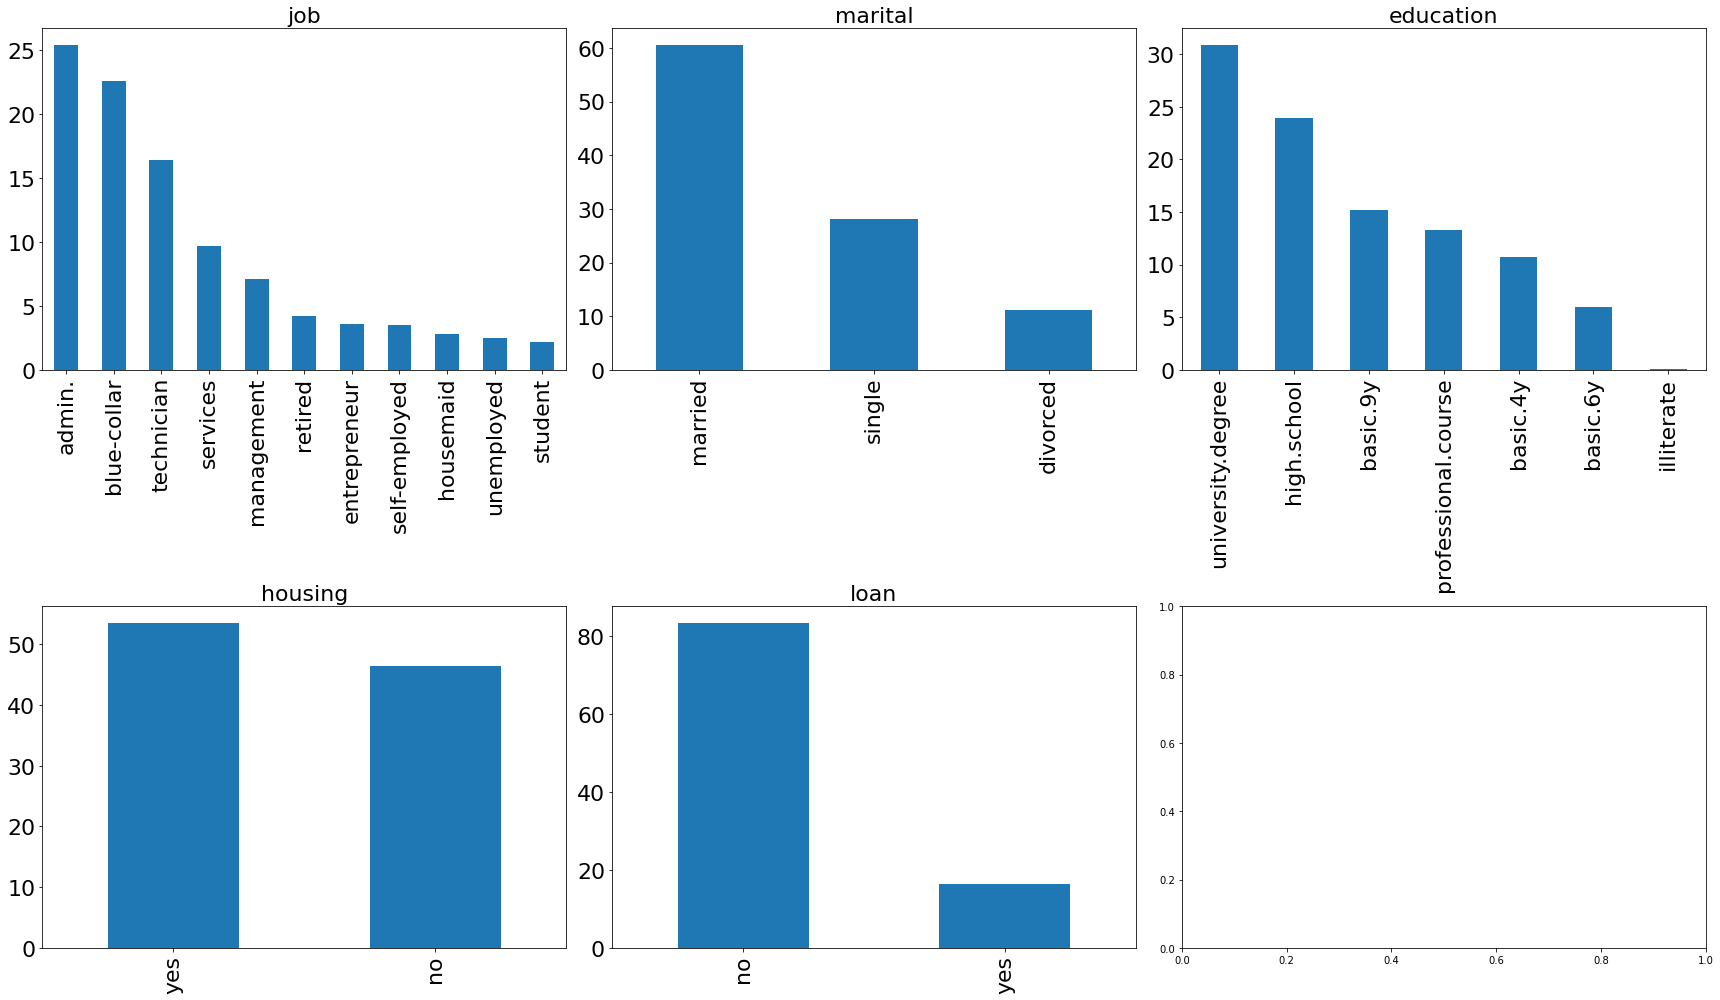

In [37]:
#draw plots to look at the distributions again
import matplotlib.pyplot as plt
categorical = ['job', 'marital', 'education', 'housing', 'loan']
#draw frequency plots for categorical variables
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(categorical,axs.reshape(-1), categorical):
   df_log_reg[i].value_counts(normalize=True).mul(100).round(1).plot(kind='bar', ax = ax)
   ax.set_title(title, fontsize = 22)
   ax.tick_params(axis='both', labelsize=22)
fig.tight_layout()
plt.show()

We can see, that in general ratio between classes within each feature is kept. Probably, in comparison with the first method this one fills missing values in a smoother way.

<b>The third approach- delete all the rows with unknown variables.</b>

Although it's not the best choice, we can perform removal of all the rows with unknown variables.

In [38]:
df_del_ukn = df.copy()
for i in df_del_ukn.columns:
    if 'unknown' in set(df_del_ukn[i]):
        df_del_ukn = df_del_ukn[df_del_ukn[i] != 'unknown']
print(f'Dataframe has {df_del_ukn.shape[0]} examples after the removal.')

Dataframe has 30478 examples after the removal.


<b>The fourth approach- develop a KNN classifier which could predict missing values</b>

In this approach, we use unsupervised machine learning, concretely K-Nearest-Neighbors algorithm. The idea is that we use a feature with unknown values as a target variable, other features as input variables and try to find the category in which each unknown value falls. We will use 10 nearest neighbors. The algorithm of preprocessing the data is similar to one we used in logistic regression, we just change the classifier.

In [8]:
#create an empty df where new filled columns will be stored
df_final_knn = pd.DataFrame()

#define a function that predicts unknown values
def fill_unknown_knn(column_name):   
   try: 
      #import necessary modules
      from sklearn.model_selection import train_test_split
      from sklearn.utils.class_weight import compute_class_weight
      from sklearn import preprocessing
      from sklearn.preprocessing import LabelEncoder
      from sklearn.neighbors import KNeighborsClassifier      
      from IPython.display import display
      import numpy as np

      #copy df
      df_copy = df.copy()

      #exclude binary features from categories
      global categories 
      categories = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
      categories = [i for i in categories if i not in [column_name, 'y', 'contact']]

      #transform another categorical features to dummy variables
      deleted_columns = []
      for i in categories:
         dummies_x = pd.get_dummies(df[i])
         deleted_columns.append(dummies_x.columns[0])
         df_copy = pd.concat([df_copy,dummies_x],axis='columns')

      #use label encoder
      le = LabelEncoder()
      #transform binary features - contact and y
      df_copy.contact = le.fit_transform(df_copy.contact)
      df_copy.y = le.fit_transform(df_copy.y)

      #delete columns - text categorical features and one from each encoded variables
      df_copy.drop(categories, axis = 1, inplace = True)
      df_copy.drop(deleted_columns, axis = 1, inplace = True)

      #split the dataframe to train set - without unknown variables and test - with unknown variables
      df_copy_train = df_copy[df_copy.loc[:, (column_name)] != 'unknown'].copy(deep = True)
      df_copy_test = df_copy[df_copy.loc[:, (column_name)] == 'unknown']
      #encode output variables
      df_copy_train['new_col'] = le.fit_transform(df_copy_train.loc[:, (column_name)])
      #assign a new column to y and drop  the column after that
      y = df_copy_train['new_col']
      df_copy_train.drop('new_col', axis = 1, inplace = True)

      #remove job column from train and test sets
      df_copy_train = df_copy_train.drop([column_name], axis='columns')
      df_copy_test = df_copy_test.drop([column_name], axis='columns')

      #Creating a model 
      #normalize data and split train set into train and validation sets
      scaler = preprocessing.StandardScaler().fit(df_copy_train)
      X_scaled = scaler.transform(df_copy_train)
      X_train, X_val, y_train, y_val = train_test_split(X_scaled,y,train_size=0.3)

      #training the model
      knn = KNeighborsClassifier(n_neighbors=10)
      knn.fit(X_train, y_train)
      knn.predict(X_val)
      print(f'Model accuracy for {column_name} is {round(knn.score(X_val, y_val) * 100, 2)} %.')

      #save the model
      # filename = 'model.pkl'
      # pickle.dump(model, open(filename, 'wb'))

      #load the model
      #pickled_model = pickle.load(open(filename, 'rb'))

      #normalize X test data
      scaler_test = preprocessing.StandardScaler().fit(df_copy_test)
      X_test_scaled = scaler_test.transform(df_copy_test)

      #predict unknown values
      prediction = knn.predict(X_test_scaled)

      #convert numbers to labels and create pd series
      df_copy_test[column_name] = le.inverse_transform(prediction)
      df_copy_test = df_copy_test[column_name].reset_index()
      df_copy_test = df_copy_test.set_index('index')

      #create a new dataframe and fill unknown values from created dataframe
      df_1 = df[df.loc[:, (column_name)] != 'unknown'].copy(deep = True)
      df_2 = df[df.loc[:, (column_name)] == 'unknown'].copy(deep = True)

      #assign pd series to a dataframe column and merge the dataframes
      df_2[column_name] = df_copy_test
      series_final = df_1.append(df_2)[column_name]
      global df_final_knn
      df_final_knn = pd.concat([df_final_knn,series_final],axis='columns')
      return df_final_knn
   except Exception as err:
      print('Since "default" feature has a little "yes" values, sometimes they are all concentrated in a cross-validation set. Please rerun the script one more time.') 
      return err

#apply the function to columns with unknown values
for i in ['job', 'marital', 'education', 'housing', 'loan', 'default']:
     df_fill = fill_unknown_knn(i)
df_fill.head()

Model accuracy for job is 47.43 %.
Model accuracy for marital is 62.34 %.
Model accuracy for education is 47.81 %.
Model accuracy for housing is 51.32 %.
Model accuracy for loan is 84.38 %.
Model accuracy for default is 99.99 %.


,job,marital,education,housing,loan,default
0,housemaid,married,basic.4y,no,no,no
1,services,married,high.school,no,no,no
2,services,married,high.school,yes,no,no
3,admin.,married,basic.6y,no,no,no
4,services,married,high.school,no,yes,no


We can see that the models perform even better than logistic regression models. However, for default feature we are not going to use this method again and keep 'unknown' class. 
Let's update initial dataframe with the filled columns and look at the new distributions.

In [9]:
new_cols = [df_fill[i] for i in df_fill.columns if i != 'default']
df_knn = df.copy()
#assign new filled columns to the old ones in the dataframe
for i,y in zip(new_cols, df_fill.columns):
  df_knn[y] = i

#check that there's no any unknown values in these columns anymore
print('Number of "unknown" occurrences:')
for i in df_knn.columns:
    if 'unknown' in set(df_knn[i]):
        print("- feature - ", i, ", number - ", len(df_knn[df_knn[i] == 'unknown']), ", percentage -", round(len(df_knn[df_knn[i] == 'unknown'])/df_knn.shape[0]*100,4), "%")
df_knn.sample(10)

Number of "unknown" occurrences:
- feature -  default , number -  8596 , percentage - 20.8762 %


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
38620,50,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,7,1,success,-3.4,92.649,-30.1,0.722,5017.5,no
21509,33,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
40278,24,student,single,professional.course,no,no,no,cellular,jul,wed,...,2,6,3,success,-1.7,94.215,-40.3,0.896,4991.6,yes
38868,34,technician,married,professional.course,no,yes,no,cellular,nov,mon,...,1,999,1,failure,-3.4,92.649,-30.1,0.714,5017.5,no
35121,48,services,married,basic.9y,unknown,no,no,cellular,may,fri,...,8,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
9379,39,blue-collar,divorced,basic.9y,no,no,no,telephone,jun,fri,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
1833,52,self-employed,married,university.degree,no,no,no,telephone,may,fri,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
11491,37,services,married,high.school,no,yes,no,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
14786,45,management,married,university.degree,unknown,no,no,cellular,jul,wed,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no
35377,29,admin.,married,high.school,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,yes


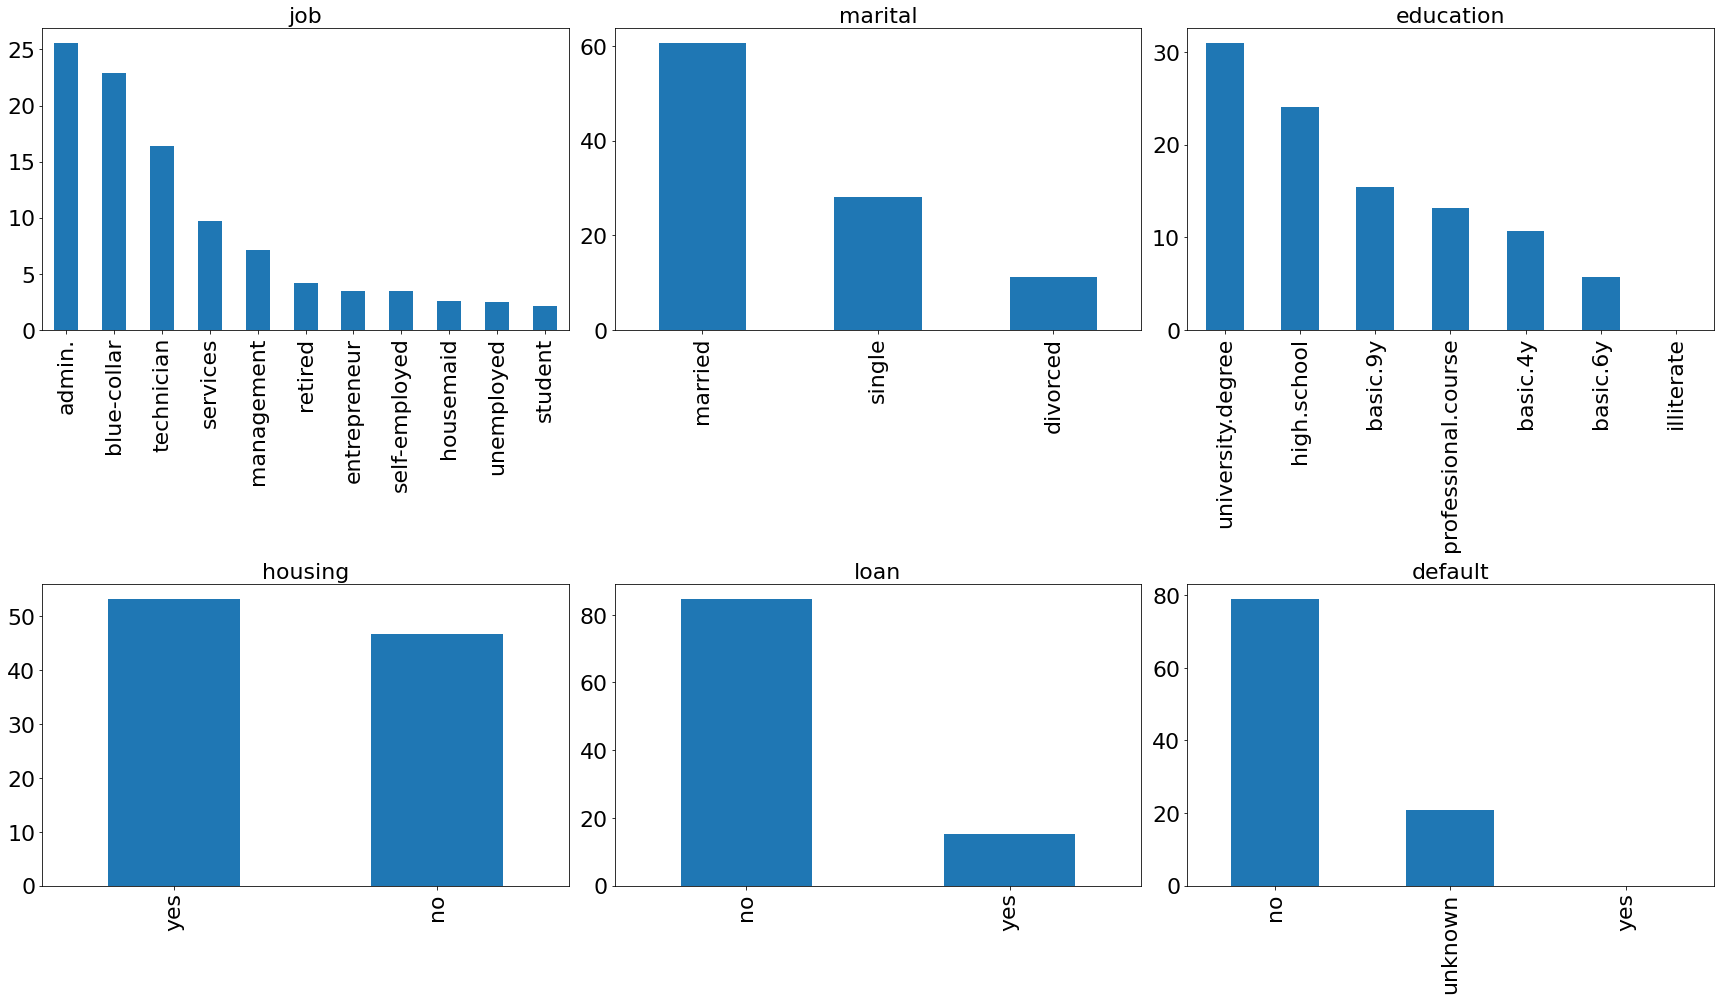

In [13]:
#draw plots to look at the distributions again
import matplotlib.pyplot as plt
categorical = ['job', 'marital', 'education', 'housing', 'loan', 'default']
#draw frequency plots for categorical variables
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(categorical,axs.reshape(-1), categorical):
   df_knn[i].value_counts(normalize=True).mul(100).round(1).plot(kind='bar', ax = ax)
   ax.set_title(title, fontsize = 22)
   ax.tick_params(axis='both', labelsize=22)
fig.tight_layout()
plt.show()

<h4>Handle otliers - three approaches</h4>
Next step is to explore the dataframe for outliers and look at summary statistics. 

<b>The first approach - using boxplot data </b>

First option for detecting outliers is to visualize them. For this purpose we can use boxplot (i.e. whisker plot). We need to find indexes of rows with outliers (according to the graphs) and remove them. We look at the graphs and set limits for each column. After that we sequentially filter dataframe columns.   

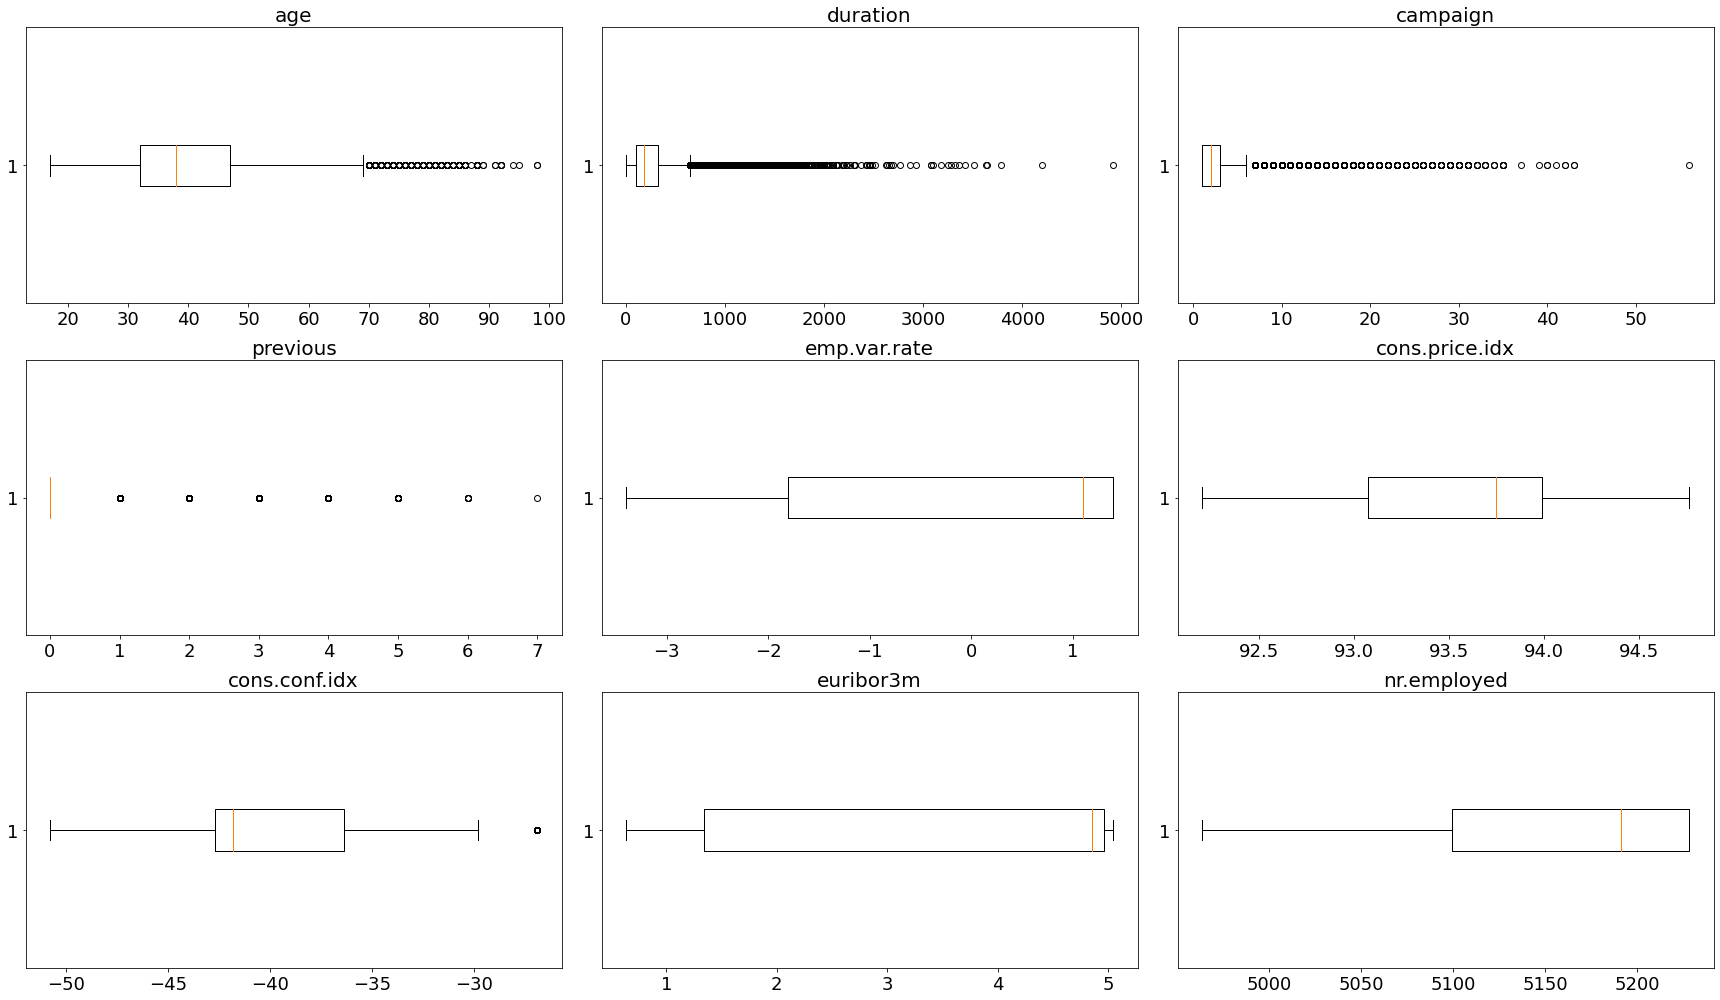

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00,41176.00
mean,40.02,258.32,2.57,0.17,0.08,93.58,-40.50,3.62,5167.03
std,10.42,259.31,2.77,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,7.00,1.40,94.77,-26.90,5.04,5228.10


In [378]:
#Graphs for outlier detection
columns = list(df.select_dtypes(exclude=['object']).columns)
columns.remove('pdays_categ')

#create list of df columns 
cols_df = [df[i] for i in columns]

import matplotlib.pyplot as plt

#draw boxplot or whisker plot
fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(cols_df,axs.reshape(-1), columns):
    bp = ax.boxplot(i, vert = 0)
    ax.set_title(title, fontsize = 20)
    ax.tick_params(axis='both', labelsize=18)
fig.tight_layout()
plt.show()

#show summary statistics
round(df[columns].describe(),2)

Let's move to the dataframe filtering.

In [19]:
import numpy as np
#reread the dataframe
df = pd.read_csv('bank-additional-full.csv', delimiter = ';')

#set columns and limits to work with
columns = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
values = [70, 800, 8, 1, 2, 100, -30, 6, 5300]
#copy the dataframe
df_boxplot = df.copy()

#extend an empty list with indexes of rows to delete
list_of_indexes = []
for i,y in zip(columns, values):
    to_del = np.where(df_boxplot[i] >= y)
    print(f'Need to remove {len(to_del[0])} outliers from {i} feature.')
    list_of_indexes.extend(to_del[0].tolist())
print(f'Total number of duplicates to remove - {len(set(list_of_indexes))}.')
delete = set(list_of_indexes)
df_boxplot.drop(delete, axis=0, inplace=True)
print(f'Number of rows after outliers removal - {df_boxplot.shape[0]}.')

#drop duplicates after deletion since a conflict with indexes of rows that were dropped as duplicates can occur
df_boxplot = df_boxplot.drop_duplicates()
print(f'Number of rows after duplicates removal - {df_boxplot.shape[0]}.')
df_boxplot.head()

Need to remove 469 outliers from age feature.
Need to remove 1767 outliers from duration feature.
Need to remove 1777 outliers from campaign feature.
Need to remove 5625 outliers from previous feature.
Need to remove 0 outliers from emp.var.rate feature.
Need to remove 0 outliers from cons.price.idx feature.
Need to remove 714 outliers from cons.conf.idx feature.
Need to remove 0 outliers from euribor3m feature.
Need to remove 0 outliers from nr.employed feature.
Total number of duplicates to remove - 9440.
Number of rows after outliers removal - 31748.
Number of rows after duplicates removal - 31737.


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Let's check the result after removal and look at the boxplots again.

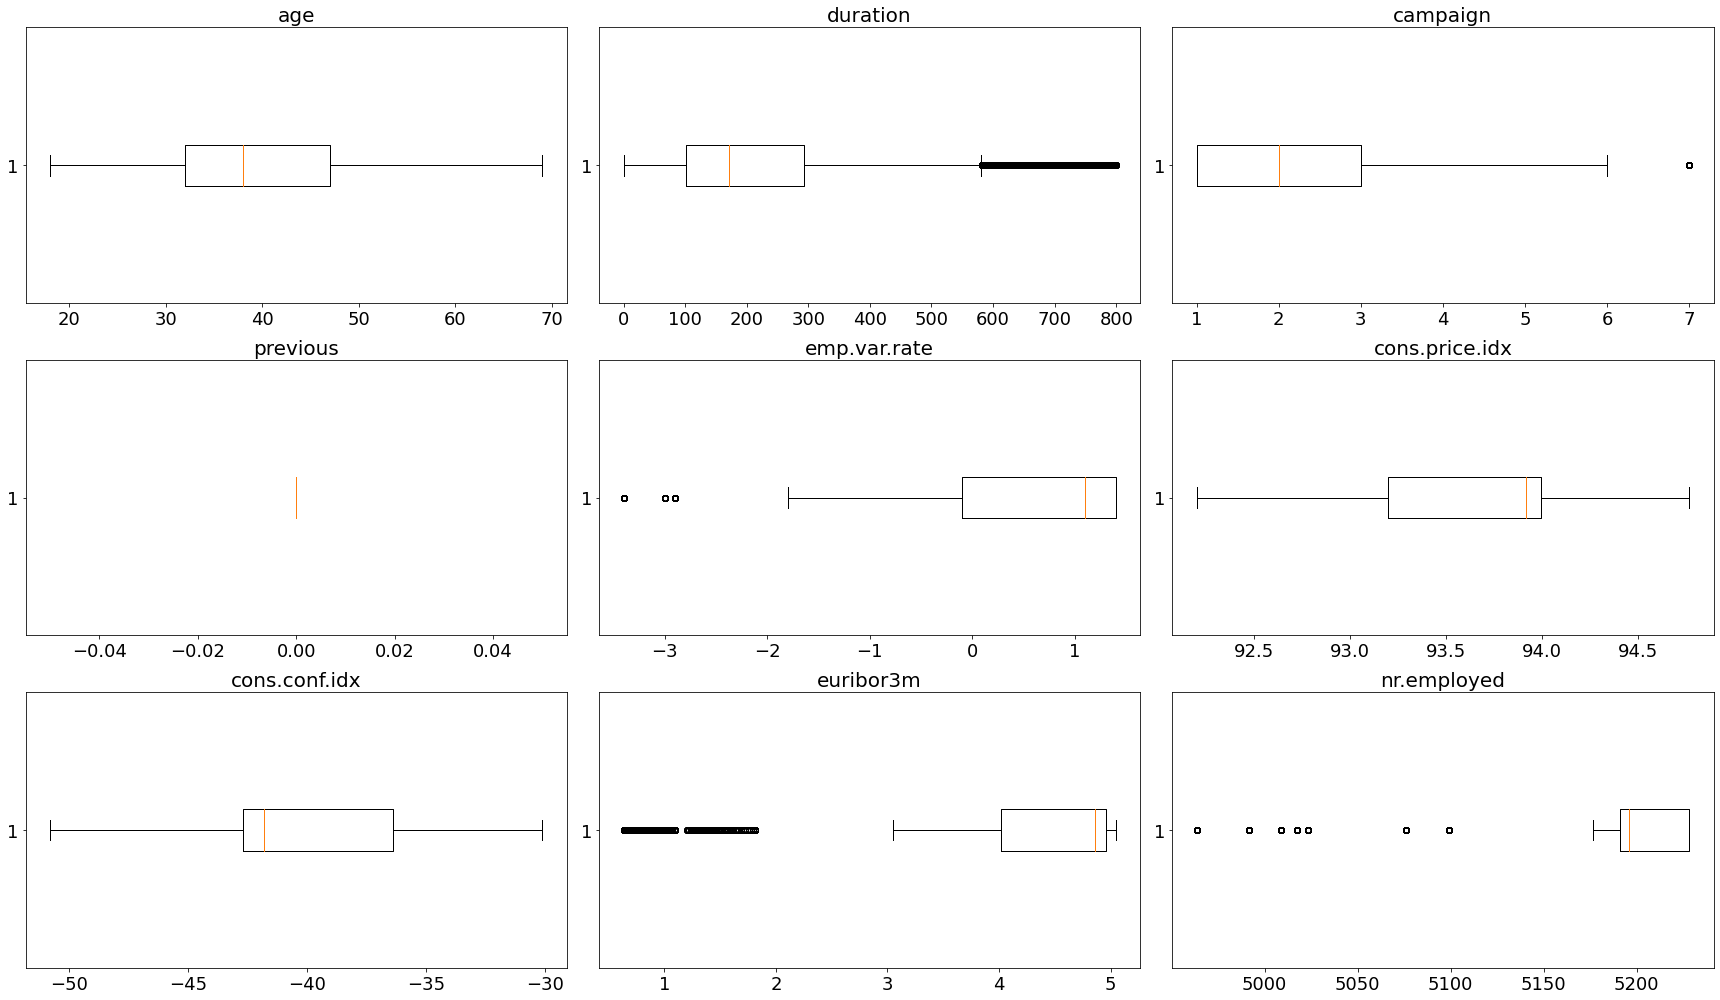

In [411]:
cols_df = [df_boxplot[i] for i in columns]

fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(cols_df,axs.reshape(-1), columns):
    bp = ax.boxplot(i, vert = 0)
    ax.set_title(title, fontsize = 20)
    ax.tick_params(axis='both', labelsize=18)
fig.tight_layout()
plt.show()

We can see that even after removal boxplot shows that new arrays also have values considered as outliers. So, it's quite hard to determine, when we should stop removing outliers. If we keep removing outliers, we can lose some essential part of information.

<b>The second approach - use quantiles</b>

This method uses IQR (Inter Quartile Range) to find and remove outliers. The idea is to calculate upper and lower bounds and remove the values beyond them.

In [413]:
import numpy as np 
#read the dataframe and drop duplicates again
df_with_outlier = df.copy()
print(f'Initial number of rows - {df_with_outlier.shape[0]}')

#define a function that removes outliers
def remove_outliers(column):
    global df_with_outlier 
    #define 1st and 3d quantile - 25% and 75%
    Q1 = np.percentile(df_with_outlier[column], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(df_with_outlier[column], 75,
                   interpolation = 'midpoint')
    #define interquantile distance               
    IQR = Q3 - Q1
    #calculate lower and upper bounds
    upper = Q3+1.5*IQR
    lower = Q3-1.5*IQR
    #filter the dataframe using the calculated bounds
    df_with_outlier = df_with_outlier[df_with_outlier[column].between(lower, upper)]

#apply the function to each numeric column
for i in columns:   #columns = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
  remove_outliers(i)

print(f'Number of rows after removing outliers using quantiles - {df_with_outlier.shape[0]}')

Initial number of rows - 41188
Number of rows after removing outliers using quantiles - 21384


Although the method is considered very reliable, we can see that if we apply outliers removing to each numeric feature, we lost essential amount of data. Even if we use 2 IQR instead of 1.5 IQR, number of remaining examples almost doesn’t change.

<b>The third approach - use z-score</b>

Z- Score is also called a standard score. This value/score helps to understand that how far is the data point from the mean. And after setting up a threshold value one can utilize z score values of data points to define the outliers.

Zscore = (data_point -mean) / std. deviation

To define an outlier threshold value is chosen which is generally 3.0. As 99.7% of the data points lie between +/- 3 standard deviation (using Gaussian Distribution approach).

In [415]:
from scipy import stats
import numpy as np
df_z = df.copy()
columns = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

list_of_indexes = []
for i in columns:
    z = np.abs(stats.zscore(df_z[i]))
    to_del = (np.where(z > 3))
    print(f'Need to remove {len(to_del[0])} outliers from {i} feature.')
    list_of_indexes.extend(to_del[0].tolist())
print(f'Number of examples to be deleted - {len(set(list_of_indexes))}.')
delete = set(list_of_indexes)
df_z.drop(delete, axis=0, inplace=True)
print(f'Number of examples after outliers removal - {df_z.shape}')

Need to remove 369 outliers from age feature.
Need to remove 861 outliers from duration feature.
Need to remove 869 outliers from campaign feature.
Need to remove 1064 outliers from previous feature.
Need to remove 0 outliers from emp.var.rate feature.
Need to remove 0 outliers from cons.price.idx feature.
Need to remove 0 outliers from cons.conf.idx feature.
Need to remove 0 outliers from euribor3m feature.
Need to remove 0 outliers from nr.employed feature.
Number of examples to be deleted - 3065.
Number of examples after outliers removal - (38123, 21)


We can see that compared to previous methods, z-score removes quite a small part of data.

In general, we can either keep or remove outliers. Usually outliers cannot be removed without analyzing. 
We could keep the outliers in age variable cause removing the oldest clients will affect the customer base understanding.
We could keep outliers in duration, campaign and previous cause they are just technical parameters and these outliers aren’t related to specific customer groups.
Also we could keep an outlier in consumer confidence index also for a reason that removing a customer with a higher confidence index will not display diversity of the customers.            

Moreover, we can see that when plotting corresponding numeric variable and y variable, there’s no outliers that lie very far. We can see it at plots below.

From the other side, not removing outliers can cause an overfitting problem in the model. When building a final model, we can compare the model performance without outliers and with them. For now, we would like to choose between keeping outliers and using z-score.

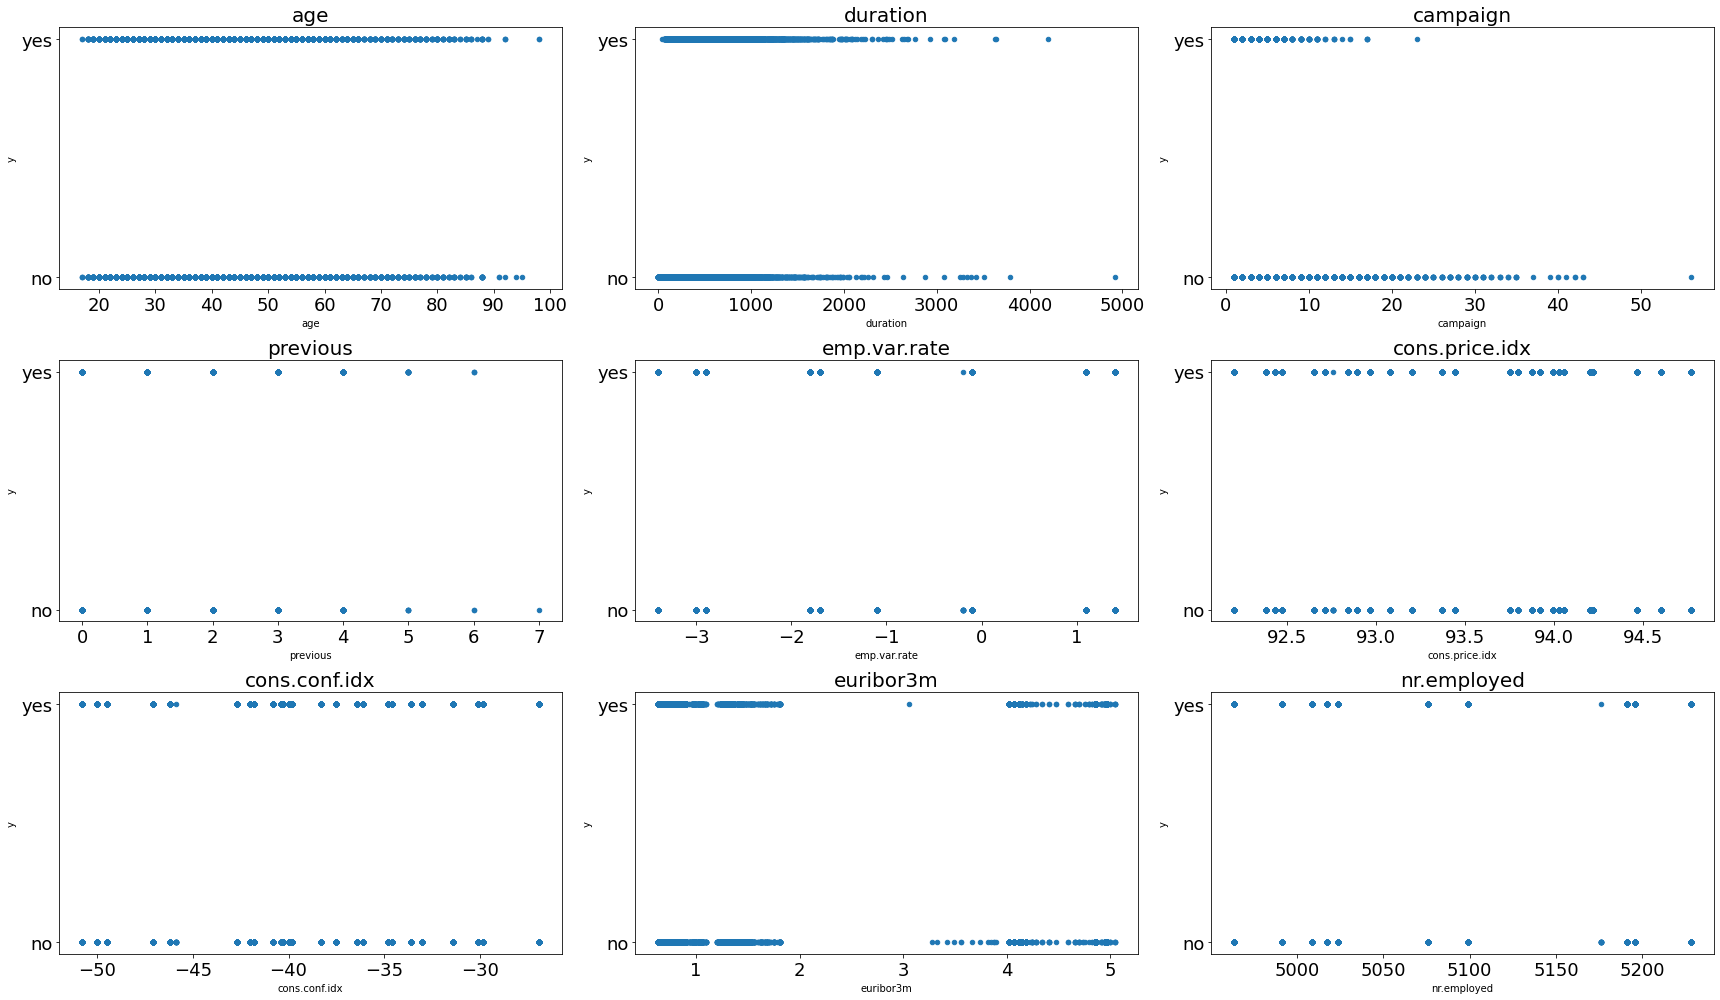

In [416]:
#plot the input variables in relation to the output variable
fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(columns,axs.reshape(-1), columns):
    bp = df.plot.scatter(i, 'y', ax = ax)
    ax.set_title(title, fontsize = 20)
    ax.tick_params(axis='both', labelsize=18)
fig.tight_layout()
plt.show()

<b>Skewed distributions - one approach</b>

As for features distributions, each distribution is quite far from a bell shape the normal distribution has. We could transform some of them to normal by applying log function. However, it becomes harder to interpret the results, so we decided to keep the variables distributions in initial condition. Anyway, we can try and see how transformed distributions can look. We can apply this method only to features, where all the values are positive. Also, there is a limitation for features with zero values cause logarithm from zero is not defined.

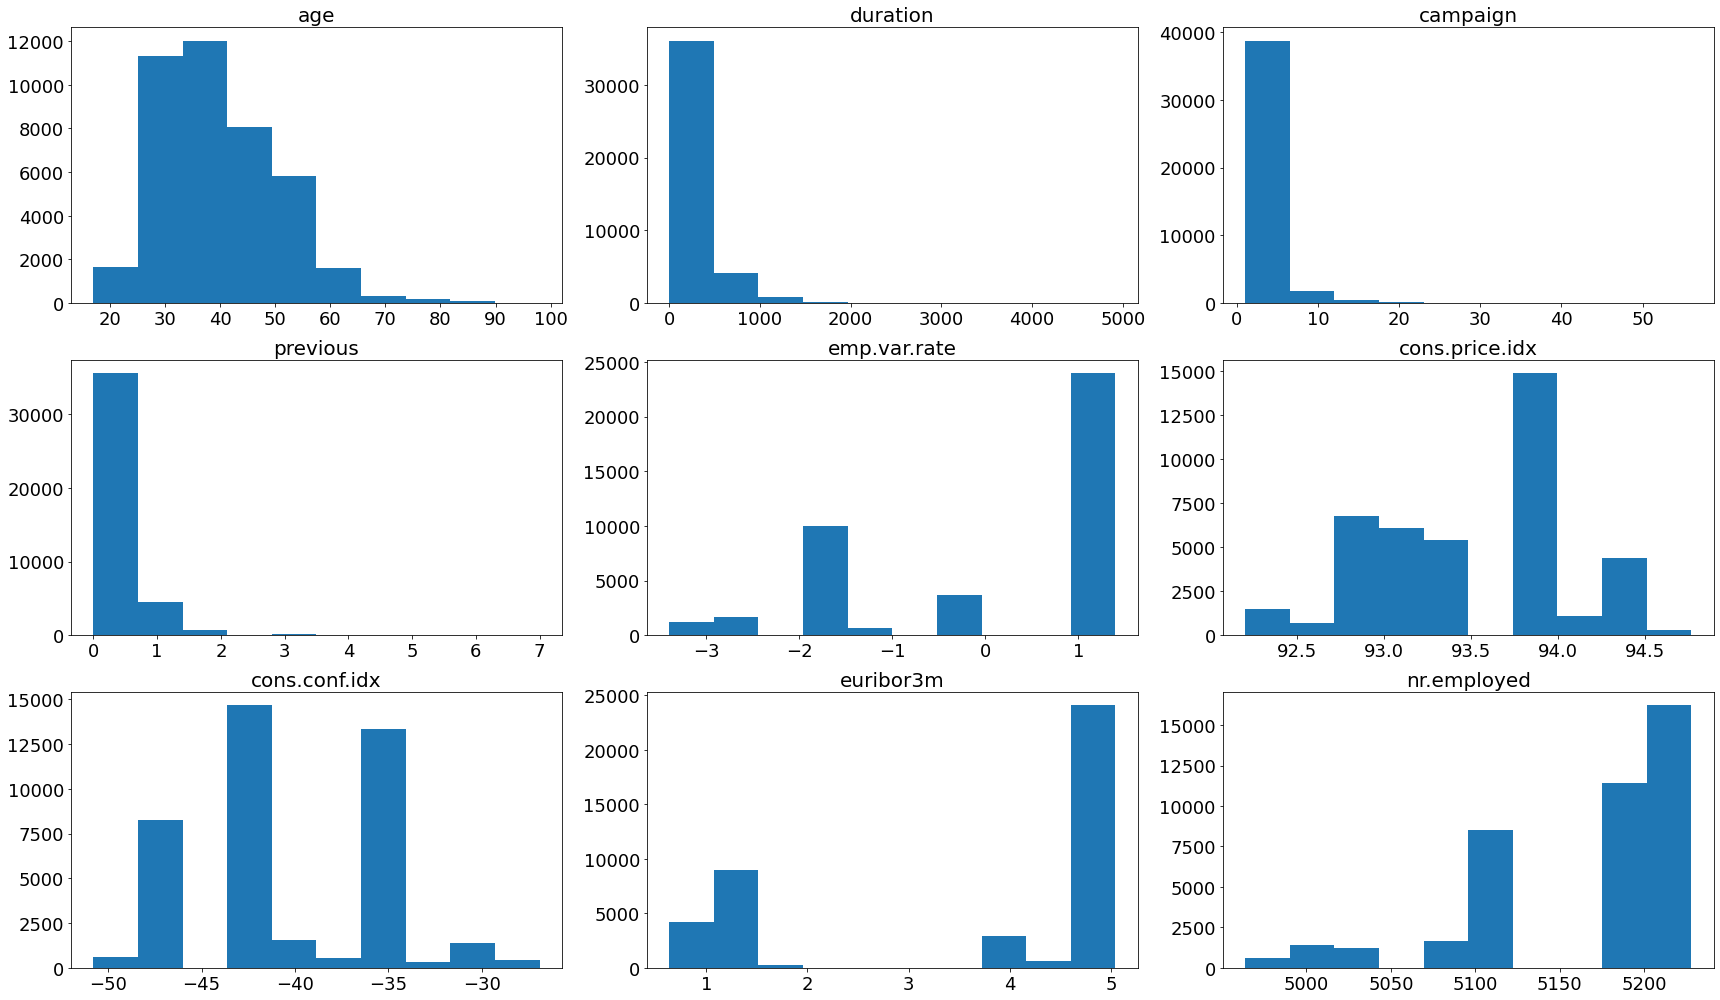

In [7]:
import matplotlib.pyplot as plt 
columns = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cols_df = [df[i] for i in columns]

#draw histogram to show distribution
fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(cols_df,axs.reshape(-1), columns):
    bp = ax.hist(i)
    ax.set_title(title, fontsize = 20)
    ax.tick_params(axis='both', labelsize=18)
fig.tight_layout()
plt.show()

In [20]:
columns = ['age', 'duration', 'campaign', 'previous', 'cons.price.idx', 'euribor3m', 'nr.employed']

df_skewed = df.copy()
for i in columns:
    df_skewed[i] = [np.log(j) if j != 0 else 0 for j in df_skewed[i]]

df_skewed.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,4.025352,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0.0,999,0.0,nonexistent,1.1,4.543231,-36.4,1.580421,8.554682,no
1,4.043051,services,married,high.school,unknown,no,no,telephone,may,mon,...,0.0,999,0.0,nonexistent,1.1,4.543231,-36.4,1.580421,8.554682,no
2,3.610918,services,married,high.school,no,yes,no,telephone,may,mon,...,0.0,999,0.0,nonexistent,1.1,4.543231,-36.4,1.580421,8.554682,no
3,3.688879,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0.0,999,0.0,nonexistent,1.1,4.543231,-36.4,1.580421,8.554682,no
4,4.025352,services,married,high.school,no,no,yes,telephone,may,mon,...,0.0,999,0.0,nonexistent,1.1,4.543231,-36.4,1.580421,8.554682,no


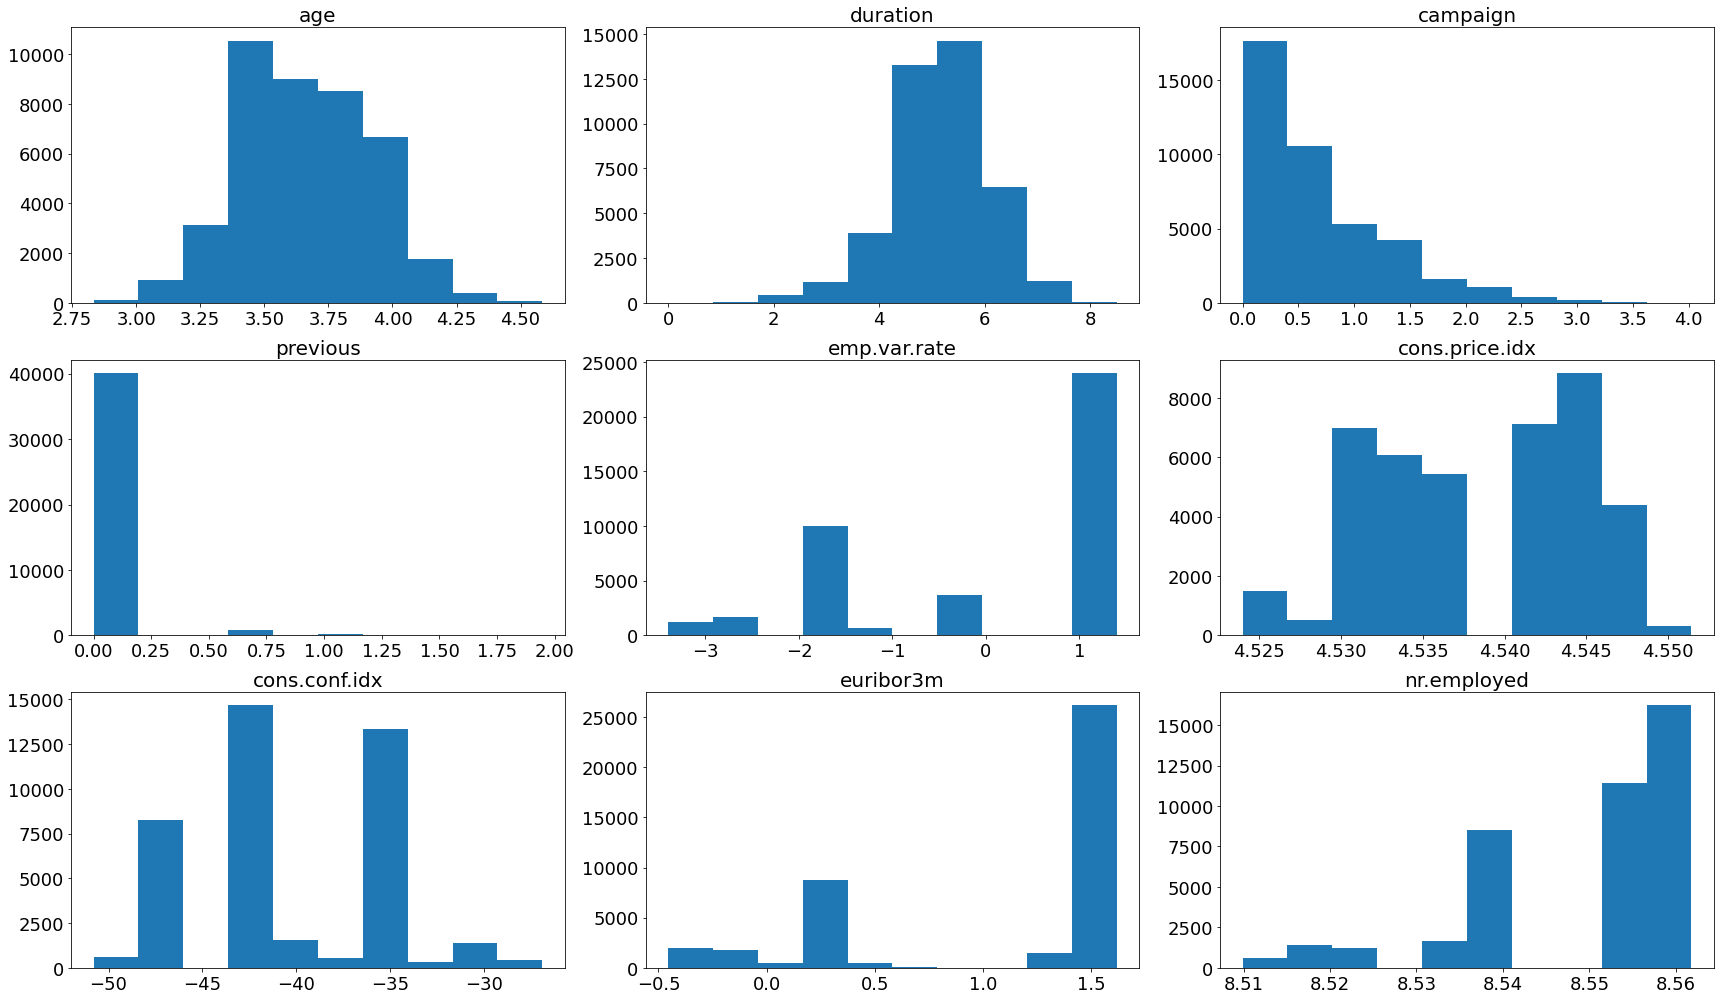

In [21]:
columns = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cols_df = [df_skewed[i] for i in columns]

#draw histogram to show distribution
fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(24, 14)
for i, ax, title in zip(cols_df,axs.reshape(-1), columns):
    bp = ax.hist(i)
    ax.set_title(title, fontsize = 20)
    ax.tick_params(axis='both', labelsize=18)
fig.tight_layout()
plt.show()

We cannot see that forms of distributions  have become closer to a bell shape in most cases. Therefore, we'd rather not use this approach and keep the distributions in an initial condition.